In [27]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import openmatrix as omx
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import seaborn as sns
sns.set(font_scale=1.5)

In [28]:
def read_matrix_from_omx_file(file, core, row_map="zone_number", col_map="zone_number"):
    if type(file) == str:
        file = omx.open_file(file)
        
    matrix_df = pd.DataFrame(file[core][:])
    if row_map is not None:
        inv_row_map = file.mapping(row_map)
        row_map = {taz1: taz2 for taz2, taz1 in inv_row_map.items()}
        inv_col_map = file.mapping(col_map)
        col_map = {taz1: taz2 for taz2, taz1 in inv_col_map.items()}
    else:
        row_map = {i: i+1 for i in range(len(matrix_df))}
        col_map = {i: i+1 for i in range(len(matrix_df))}
    matrix_df.rename(index=row_map, columns=col_map, inplace=True)
    return matrix_df

In [29]:
output_dir = r'C:\ABM3_dev\visualizer\output'

In [30]:
households = pd.read_csv(os.path.join(output_dir, 'final_households.csv'))
persons = pd.read_csv(os.path.join(output_dir, 'final_persons.csv'))
tours = pd.read_csv(os.path.join(output_dir, 'final_tours.csv'))
trips = pd.read_csv(os.path.join(output_dir, 'final_trips.csv'))
landuse = pd.read_csv(os.path.join(output_dir, 'final_land_use.csv'))

C:\Users\davidh\AppData\Local\Temp\17\ipykernel_265684\2432087234.py:3: DtypeWarning: Columns (15,16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(output_dir, 'final_tours.csv'))
C:\Users\davidh\AppData\Local\Temp\17\ipykernel_265684\2432087234.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(os.path.join(output_dir, 'final_trips.csv'))


In [31]:
households.joint_tour_frequency_composition.value_counts()

0.0      105763
1.0       30373
13.0      28796
15.0      26620
4.0       22795
          ...  
64.0         11
100.0         9
98.0          6
109.0         5
62.0          5
Name: joint_tour_frequency_composition, Length: 106, dtype: int64

In [32]:
md_skims = omx.open_file(r'C:\ABM3_dev\data_2_crop\traffic_skims_processed_MD.omx')
sov_md_dist = read_matrix_from_omx_file(md_skims, 'SOV_TR_M_DIST__MD', 'ZONE', 'ZONE')
sov_md_dist = sov_md_dist.melt(ignore_index=False).reset_index()
sov_md_dist.columns = ['origin', 'destination', 'dist']

In [33]:
sov_md_dist.head()

,origin,destination,dist
0,3543,3543,0.261287
1,3563,3543,0.650724
2,3581,3543,1.754474
3,3652,3543,0.965275
4,3664,3543,1.296256


In [34]:
households

,household_id,home_zone_id,income,hhsize,HHT,auto_ownership,num_workers,sample_rate,income_in_thousands,income_segment,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_6_to_12,num_children_5_to_15,num_children_16_to_17,num_gradeschool,num_highschool,num_college_age,num_young_adults,num_predrive_child,num_nonworker_adults,num_university_students,num_fullTime_workers,num_partTime_workers,num_retired_adults,non_family,family,home_is_urban,home_is_rural,num_hh_in_zone,hh_work_auto_savings_ratio,transponder_ownership,has_joint_tour,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,school_escorting_outbound,school_escorting_inbound,school_escorting_outbound_cond,auPkRetail,auPkTotal,auOpRetail,auOpTotal,...,zip09,parkactive,openspaceparkpreserve,beachactive,budgetroom,economyroom,luxuryroom,midpriceroom,upscaleroom,hotelroomtotal,luz_id,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,totint,duden,empden,popden,retempden,totintbin,empdenbin,dudenbin,PopEmpDenPerMi,poe_id,original_MAZ,external_TAZ,external_MAZ,external_size_term_placeholder,colonia_pop_accessibility,external_work,external_nonwork,ML_DIST,AVGTTS,PCTDETOUR,household_density,population_density,employment_density,density_index,is_cbd,tot_collegeenroll,preschool_target,is_parking_zone,joint_tour_frequency_composition,num_hh_joint_tours
0,3,16,236389,2,3,1,0,0.251,236.389,4,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,0,0,False,True,False,False,9,0.0,False,0,0,2,1,0,1,2,True,3,3,3,9.952910,12.398537,10.025399,12.475621,...,92103,0.2885,2.6246,0.0,0,0,0,0,0,0,95,1,27,4.1787,12.9617,12.9617,12.9617,10,0,0,163,4.5000,2.3031,9.9589,0.3880,3,1,1,7847.7009,-1,-1,-1,-1,0,NaN,0.0,0.0,8.3927,0.04958,0.0,4.320421,9.643797,0.308601,0.288028,False,0,128,True,15.0,1
1,4,27,121977,2,2,2,2,0.251,121.977,4,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,False,True,False,False,13,0.0,False,1,0,2,2,0,0,2,True,1,1,1,10.000264,12.427243,10.060798,12.494185,...,92103,0.0000,0.9152,0.0,0,0,0,0,0,0,95,1,27,3.5366,13.5213,13.3853,13.5213,10,0,0,86,2.2541,12.5055,5.2245,5.8081,2,2,1,11347.2370,-1,-1,-1,-1,0,NaN,0.0,0.0,8.2293,0.05137,0.0,3.106210,7.099909,0.073957,0.072237,False,0,96,True,7.0,1
2,9,43,126505,4,1,4,3,0.251,126.505,4,1,4,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,False,True,False,False,4,0.0,False,1,0,4,4,0,0,4,True,1,1,1,10.044018,12.486473,10.114745,12.559941,...,92103,0.0000,0.0000,0.0,0,0,0,0,0,0,95,1,27,3.8598,9.4214,9.4214,9.4214,10,0,0,151,4.0263,2.4693,9.2070,0.5603,3,1,1,7472.8537,-1,-1,-1,-1,0,NaN,0.0,0.0,8.4439,0.05026,0.0,4.139512,9.765003,1.167555,0.910693,False,0,102,True,13.0,1
3,12,50,102770,2,5,2,2,0.251,102.770,4,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,True,False,False,False,7,0.0,False,1,0,2,2,0,0,2,True,1,1,1,10.044018,12.486473,10.114745,12.559941,...,92103,0.0000,0.0000,0.0,0,0,0,0,0,0,95,1,27,3.8339,9.9034,9.9034,9.9034,10,0,0,113,4.5646,11.5938,9.8938,2.1309,2,2,1,13752.0487,-1,-1,-1,-1,0,NaN,0.0,0.0,8.4439,0.05026,0.0,3.130238,7.068280,0.100975,0.097820,False,0,70,True,7.0,1
4,15,17,234965,2,1,2,1,0.251,234.965,4,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,False,True,False,False,5,0.0,False,1,0,2,2,0,0,2,True,1,1,1,9.952910,12.398537,10.025399,12.475621,...,92103,0.0000,1.6993,0.0,0,0,0,0,0,0,95,1,27,4.1402,4.0625,4.0625,4.0625,10,0,0,149,4.6408,1.8327,10.2312,0.3810,3,1,1,7720.8591,-1,-1,-1,-1,0,NaN,0.0,0.0,8.3927,0.04958,0.0,2.953846,6.153846,0.000000,0.000000,False,0,25,True,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Household Variables

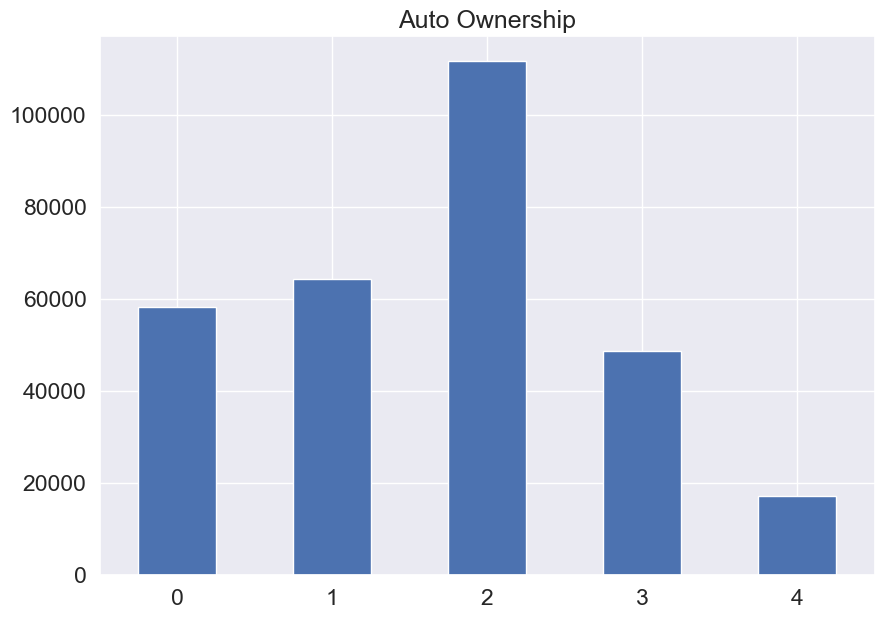

In [35]:
plt.figure(figsize=(10,7))
households.auto_ownership.value_counts().loc[[0,1,2,3,4]].plot(kind='bar')
plt.title('Auto Ownership')
plt.xticks(rotation=0)
plt.show()

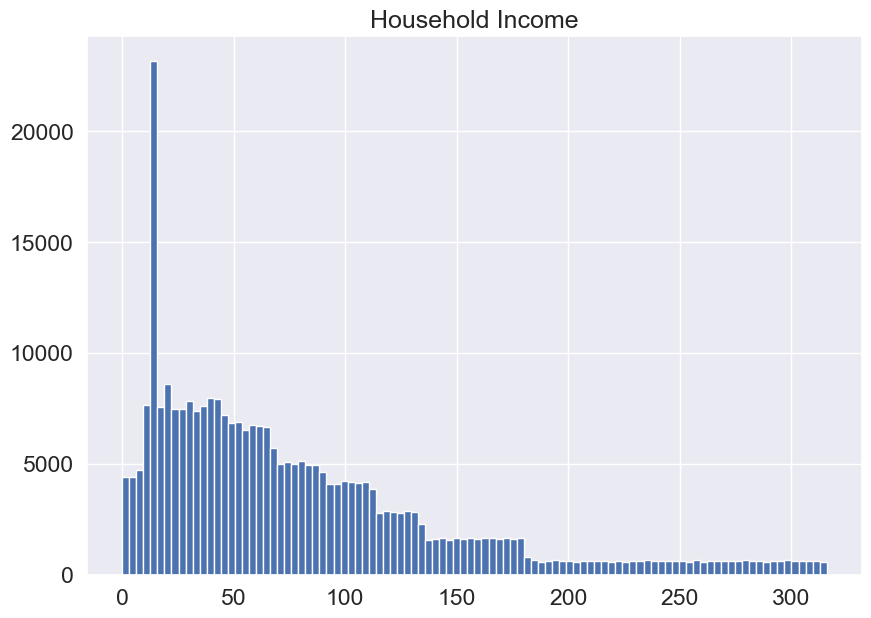

In [36]:
plt.figure(figsize=(10,7))
households.income_in_thousands.hist(bins=100)
plt.title('Household Income')
plt.show()

In [37]:
households.income_in_thousands.value_counts()

14.000     15739
20.380        91
4.529         86
24.909        85
29.437        83
           ...  
101.275        1
53.235         1
80.576         1
60.339         1
191.273        1
Name: income_in_thousands, Length: 123803, dtype: int64

Lots of households have an annual income of exactly $14,000

## Person Variables

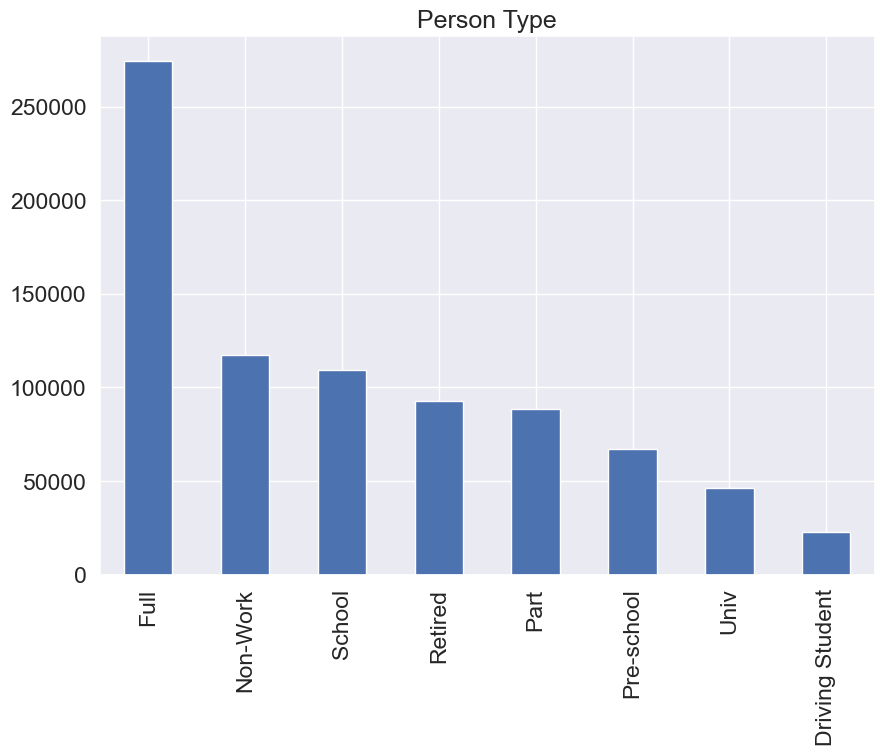

In [38]:
person_type_dict = {
    1: 'Full',
    2: 'Part',
    3: 'Univ',
    4: 'Non-Work',
    5: 'Retired',
    6: 'Driving Student',
    7: 'School',
    8: 'Pre-school'
}
persons['ptype_named'] = persons['ptype'].map(person_type_dict)

plt.figure(figsize=(10,7))
persons.ptype_named.value_counts().plot(kind='bar')
plt.title('Person Type')
plt.show()

## Purpose

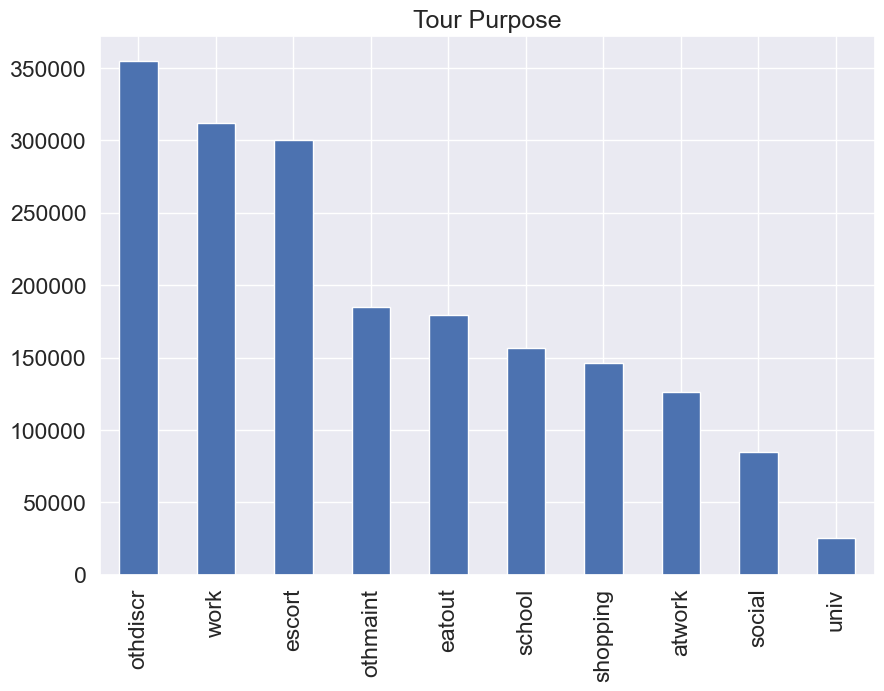

In [39]:
plt.figure(figsize=(10,7))
tours.primary_purpose.value_counts().plot(kind='bar')
plt.title('Tour Purpose')
plt.show()

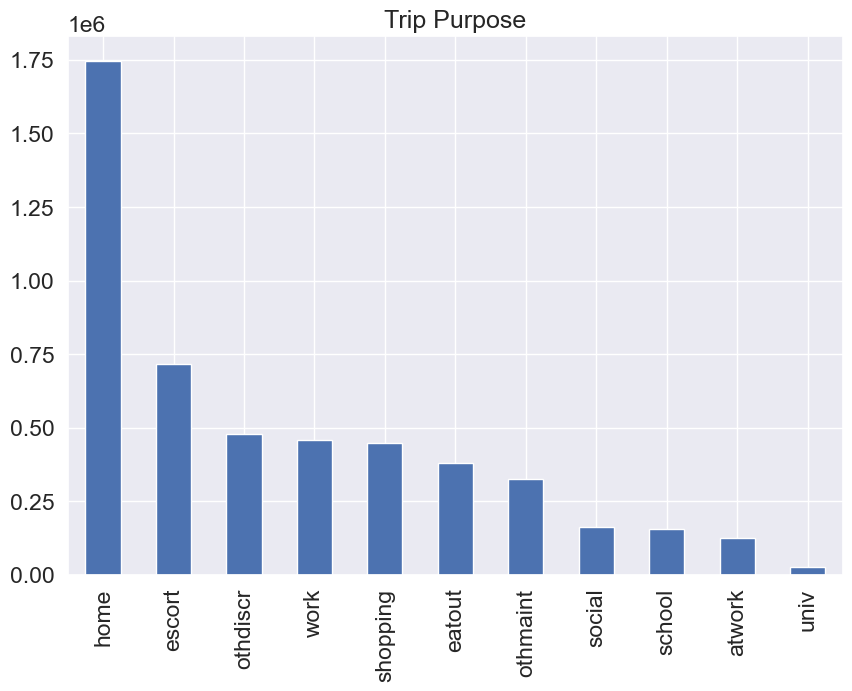

In [40]:
plt.figure(figsize=(10,7))
trips.purpose.value_counts().plot(kind='bar')
plt.title('Trip Purpose')
plt.show()

## Mode

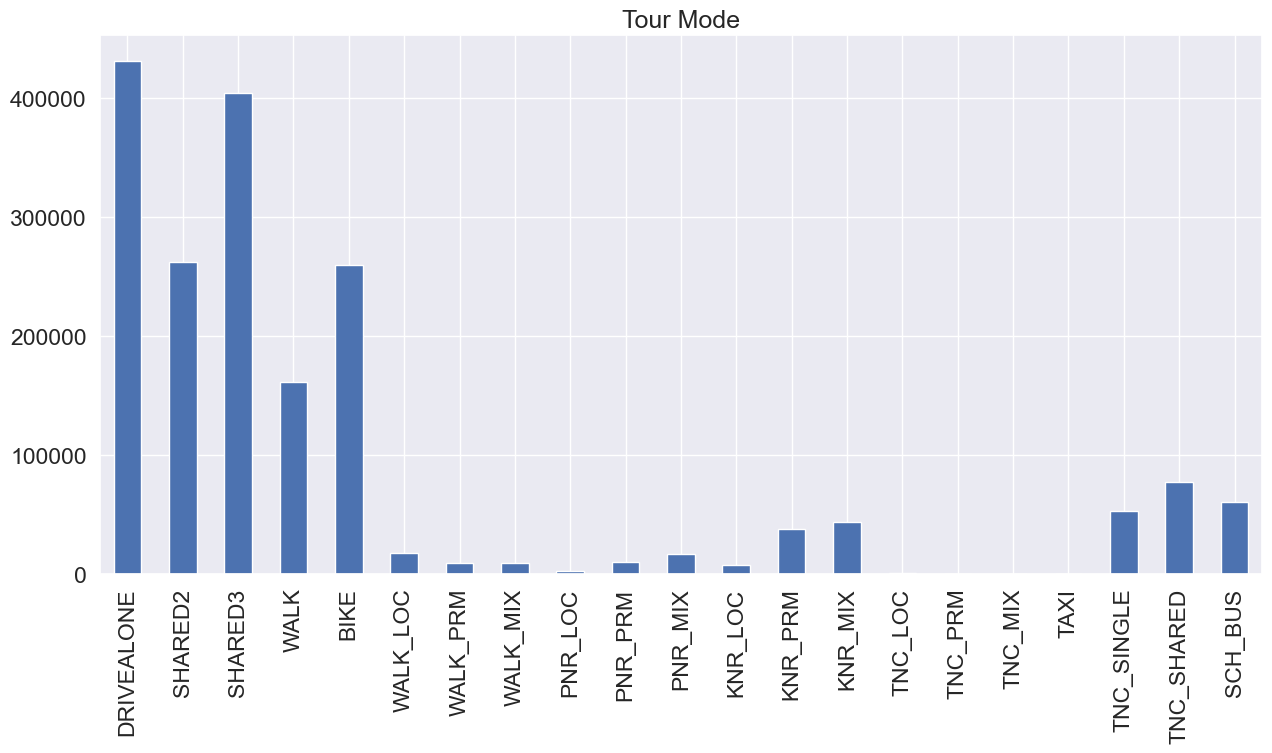

In [41]:
mode_order = ['DRIVEALONE','SHARED2','SHARED3','WALK','BIKE','WALK_LOC', 'WALK_PRM', 'WALK_MIX','PNR_LOC', 'PNR_PRM', 'PNR_MIX','KNR_LOC', 'KNR_PRM', 'KNR_MIX','TNC_LOC', 'TNC_PRM', 'TNC_MIX','TAXI','TNC_SINGLE','TNC_SHARED','SCH_BUS']
tour_modes = tours.tour_mode.value_counts()
missing_modes = [mode for mode in mode_order if mode not in tour_modes.index]
for missing_mode in missing_modes:
    tour_modes.loc[missing_mode] = 0

plt.figure(figsize=(15,7))
tour_modes.loc[mode_order].plot(kind='bar')
plt.title('Tour Mode')
plt.show()

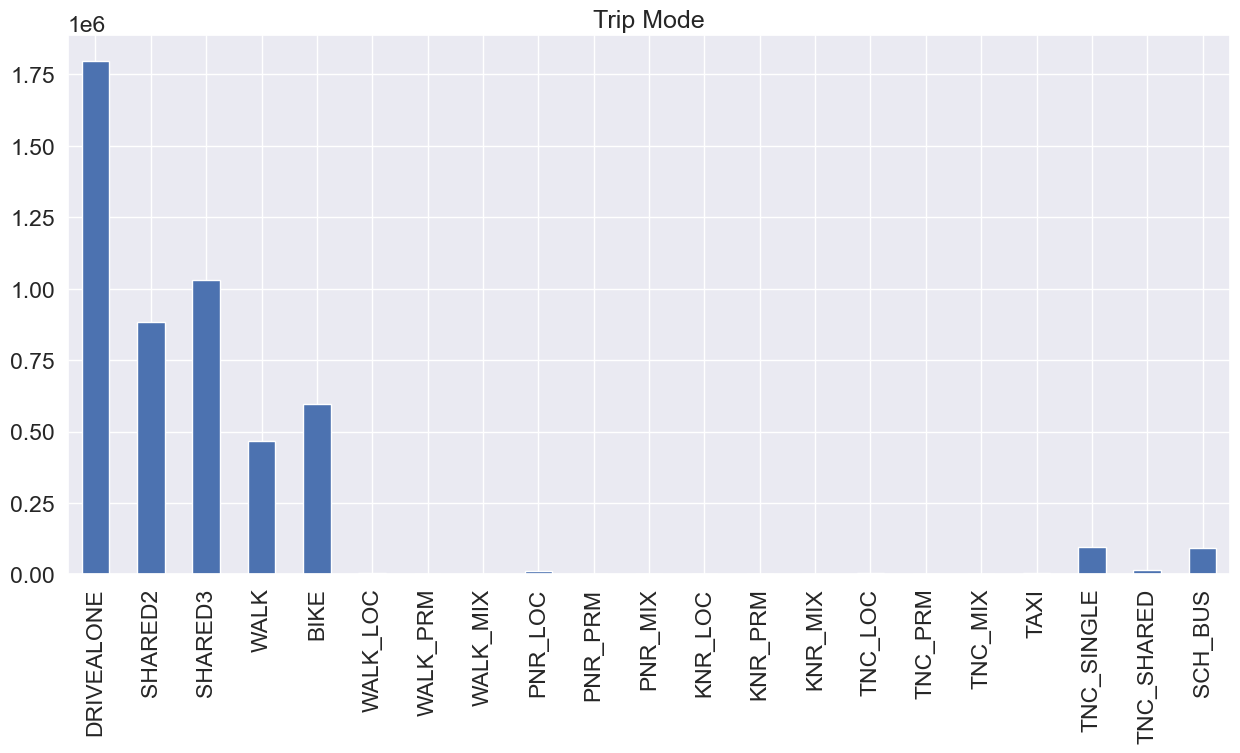

In [42]:
trip_modes = trips.trip_mode.value_counts()
missing_modes = [mode for mode in mode_order if mode not in trip_modes.index]
for missing_mode in missing_modes:
    trip_modes.loc[missing_mode] = 0

plt.figure(figsize=(15,7))
trip_modes.loc[mode_order].plot(kind='bar')
plt.title('Trip Mode')
plt.show()

In [43]:
trip_modes

DRIVEALONE    1796181
SHARED3       1031116
SHARED2        884833
BIKE           595077
WALK           466331
TNC_SINGLE      95698
SCH_BUS         94136
TNC_SHARED      13856
PNR_LOC         11849
TAXI             5247
WALK_LOC         4380
TNC_LOC          4105
TNC_PRM          3203
KNR_PRM          3030
KNR_LOC          2825
TNC_MIX          2695
PNR_PRM          2599
PNR_MIX          2305
KNR_MIX          2285
WALK_PRM         1929
WALK_MIX         1223
Name: trip_mode, dtype: int64

## Scheduling

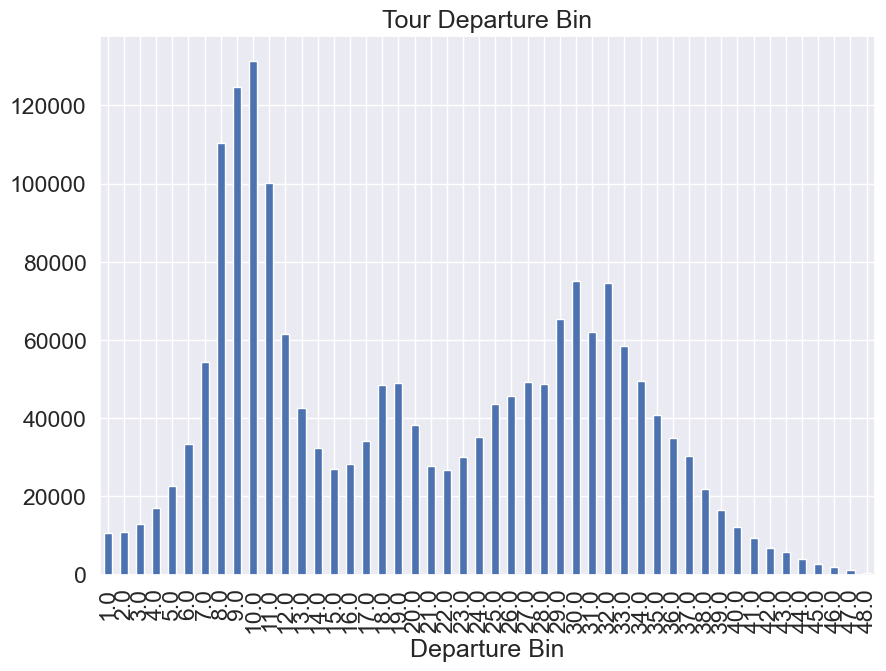

In [44]:
plt.figure(figsize=(10,7))
tours.start.value_counts().loc[range(1,49)].plot(kind='bar')
plt.title('Tour Departure Bin')
plt.xlabel('Departure Bin')
plt.show()

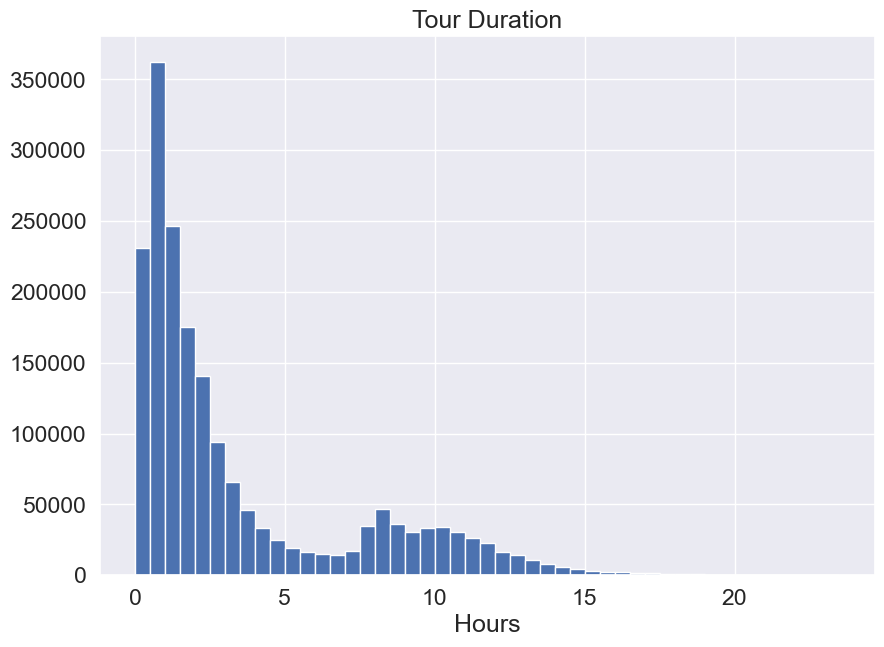

In [45]:
plt.figure(figsize=(10,7))
(tours.duration / 2).hist(bins=47)
plt.title('Tour Duration')
plt.xlabel('Hours')
plt.show()

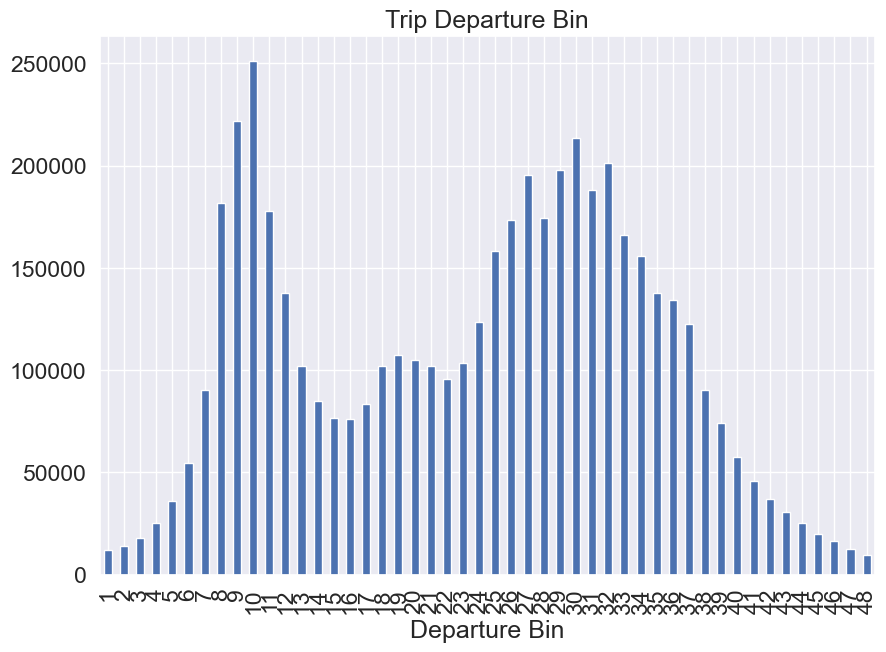

In [46]:
plt.figure(figsize=(10,7))
trips.depart.value_counts().loc[range(1,49)].plot(kind='bar')
plt.title('Trip Departure Bin')
plt.xlabel('Departure Bin')
plt.show()

## Location Choice

In [47]:
maz_taz_xwalk = landuse.set_index('zone_id')['TAZ'].to_dict()
tours['origin_taz'] = tours['origin'].map(maz_taz_xwalk)
tours['destination_taz'] = tours['destination'].map(maz_taz_xwalk)

trips['origin_taz'] = trips['origin'].map(maz_taz_xwalk)
trips['destination_taz'] = trips['destination'].map(maz_taz_xwalk)

tours_with_dist = pd.merge(tours, sov_md_dist, how='left', left_on=['origin_taz', 'destination_taz'], right_on=['origin', 'destination'])
trips_with_dist = pd.merge(trips, sov_md_dist, how='left', left_on=['origin_taz', 'destination_taz'], right_on=['origin', 'destination'])

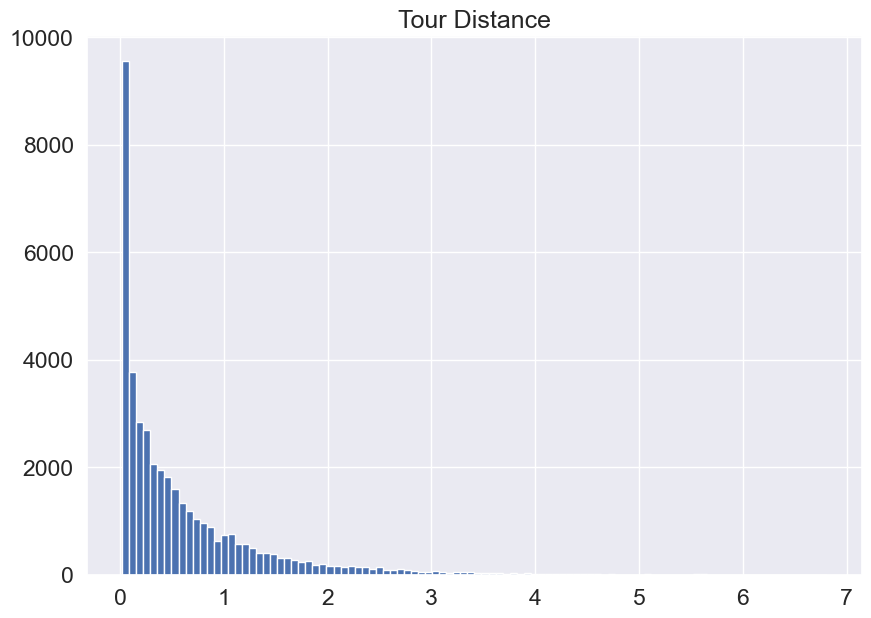

In [48]:
plt.figure(figsize=(10,7))
tours_with_dist.dist.hist(bins=100)
plt.title('Tour Distance')
plt.show()

In [49]:
tours_with_dist[tours_with_dist.dist > 80].primary_purpose.value_counts()

Series([], Name: primary_purpose, dtype: int64)

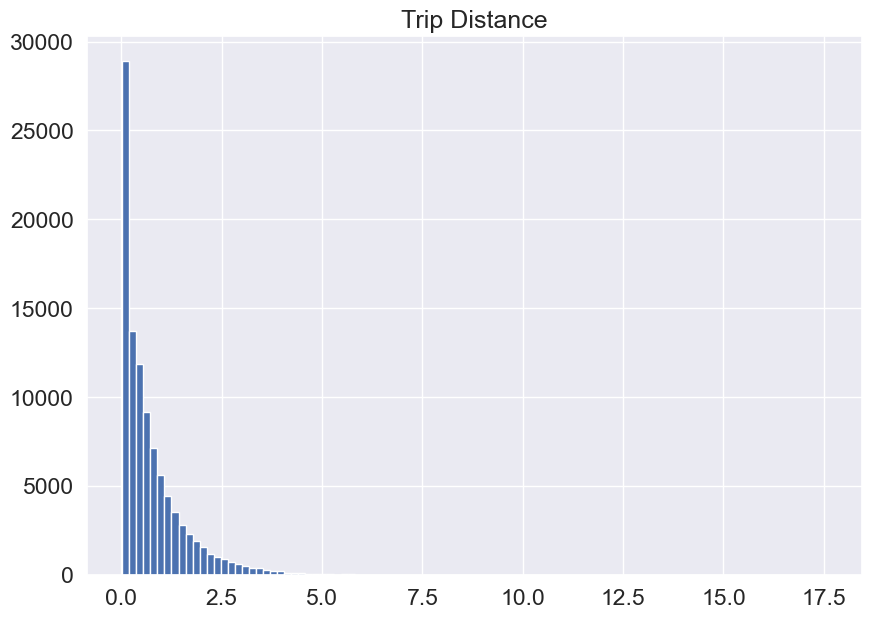

In [50]:
plt.figure(figsize=(10,7))
trips_with_dist.dist.hist(bins=100)
plt.title('Trip Distance')
plt.show()

In [51]:
trips_with_dist[trips_with_dist.dist > 80].purpose.value_counts()

Series([], Name: purpose, dtype: int64)

Some school tours and trips are very long!!

## Timing

In [52]:
timing_log = pd.read_csv(os.path.join(output_dir, 'log', 'timing_log.csv'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\ABM3_dev\\visualizer\\output\\log\\timing_log.csv'

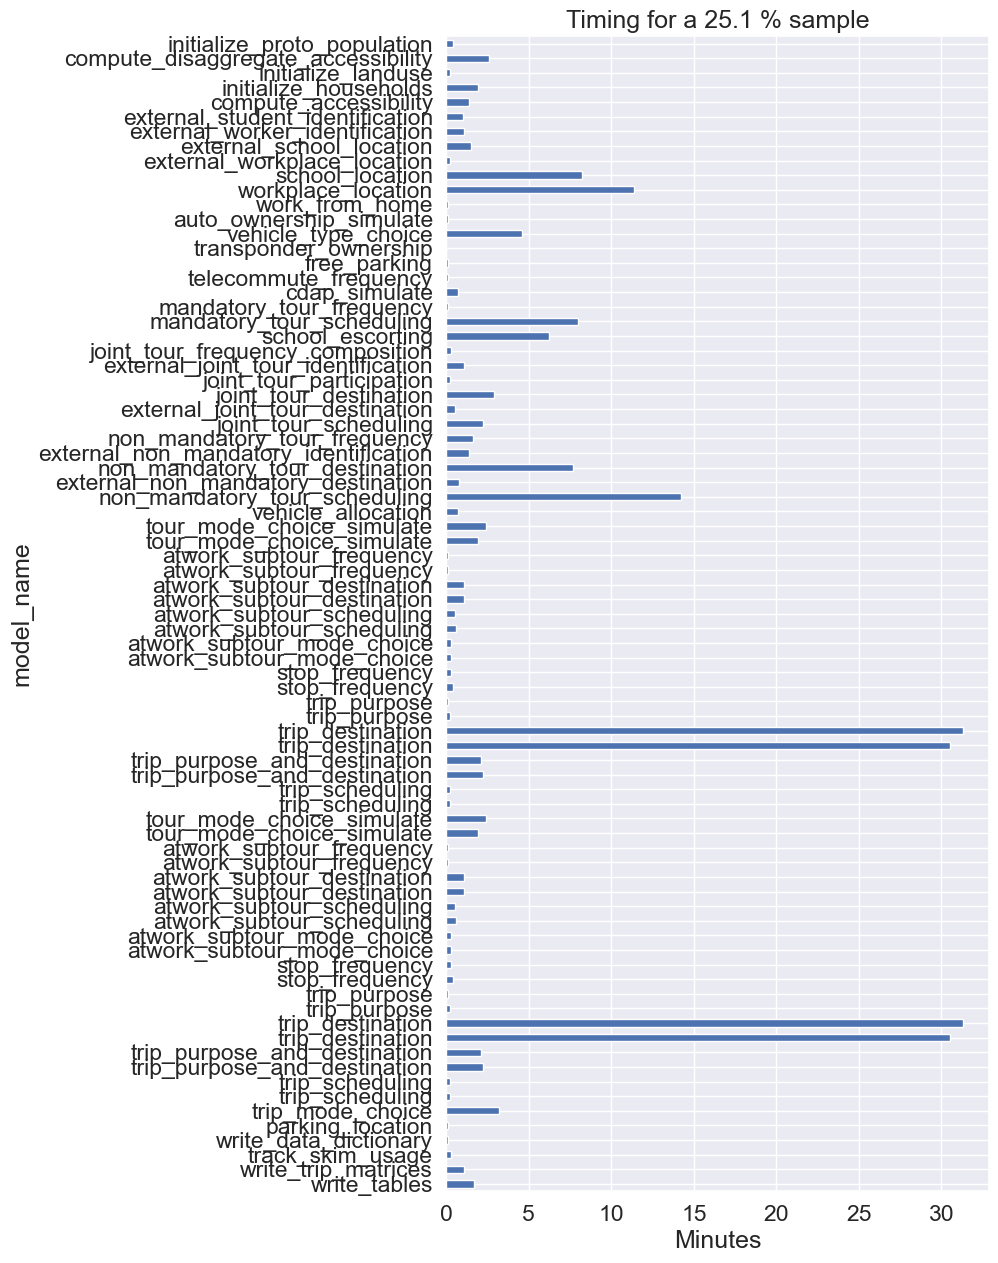

Total model run time: 165.9 minutes = 2.765 hours


In [ ]:
plt.show()
order = timing_log.loc[timing_log.index.sort_values(ascending=False),'model_name'].values
plt.figure(figsize=(7,15))
timing_log.set_index('model_name').loc[order].minutes.plot.barh()
plt.xlabel('Minutes')
plt.title(f'Timing for a {round(households.sample_rate.mean()*100, 1)} % sample')
plt.show()
print(f"Total model run time: {timing_log.minutes.sum()} minutes = {timing_log.minutes.sum() / 60} hours")

While timing log says run took only 84 mins, the anaconda prompt has a time of 124.6 mins to complete....

## Trip Purpose and Destination
What is the profile of failed trips?

In [ ]:
trips

In [ ]:
failed_trips = pd.read_csv(os.path.join(output_dir, 'trip_purpose_and_destination_i5_failed_trips.csv'))

In [ ]:
failed_trips = pd.merge(failed_trips, tours, how='left', on='tour_id', suffixes=('', '_tour'))

In [ ]:
failed_trips.tour_mode.value_counts()

In [ ]:
failed_trips.origin.value_counts()

In [ ]:
landuse[landuse.zone_id.isin(failed_trips.origin)]